# 1D Layered Earth model using `SimPEG`



In [2175]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time
from datetime import datetime
  
# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
import SimPEG
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## load the model and survey

In [2176]:
# 1D background
depth = [0., -600, -850, -3150]
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]

# Define dimensions of the three blocks [x1, x2, y1, y2, z1, z2]
block1 = [ -500,  500, -4000, 4000,  -1600, -850]
block2 = [    0, 5000, -3000,    0,  -1850, -1600]
block3 = [-5000,    0,     0, 3000, -2900, -1600]

# Resistivities Block 1, 2, and 3
resistivities = [10, 100, 500]

In [2177]:
ds = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')

In [2178]:
# Get Survey
src = ds.attrs['src']
strength = ds.attrs['strength']
freq = ds.attrs['freq']
rec_x = ds.x.data[::2]
rec_y = ds.attrs['rec_y']
rec_z = ds.attrs['rec_z']
rx_locs = discretize.utils.ndgrid([rec_x, rec_y, np.r_[rec_z]])

# Get source center (for meshing)
src_c = np.mean(src.reshape(-1, 2), 1)
print(src)

[-100.  100.    0.    0. -550. -550.]


In [2180]:
print(
    f"skin depth: {503/np.sqrt(freq/np.unique(res1d))}"
)

skin depth: [2.75504446e+02 5.03000000e+02 7.11349422e+02 1.59062566e+04
 5.03000000e+06]


## create a computational mesh

Start by defining the underlying tensor mesh

In [2181]:
# dx, dy, dz = 100, 200, 50 
# domain_x, domain_y, domain_z = 2e4, 6e3, np.abs(depth).max()

# ncore_x = domain_x/dx
# ncore_y = domain_y/dy
# ncore_z = domain_z/dz

# print(ncore_x, ncore_y, ncore_z, ncore_x*ncore_y*ncore_z)

# npad_x = 18
# npad_y = 10
# npad_z = 20

# ncx = 2**int(np.ceil(np.log(ncore_x + npad_x*2)/np.log(2.)))
# ncy = 2*2**int(np.ceil(np.log(ncore_y + npad_y*2)/np.log(2.)))
# ncz = 2**int(np.ceil(np.log(ncore_z + npad_z*2)/np.log(2.)))

# print(ncx, ncy, ncz, ncx*ncy*ncz)

# pf = 1.35
# pfz = 1.35

In [2183]:
mesh_b = discretize.TensorMesh.readUBC("mesh_tensor")

In [2189]:
rhoh_b = mesh_b.readModelUBC("rhoh.mod")
rhov_b = mesh_b.readModelUBC("rhov.mod")

In [2190]:
ncore_z * 50

3150.0

In [2191]:
# ncx = 220
# ncy = 2
# ncz = 17
# npad_x = 10
# npad_y = 10
# npad_z = 15
# pf = 1.35
# pfz = 1.35
# hx = [(dx, npad_x, -pf), (dx, ncx), (dx, npad_x, pf)]
# hy = [(dy, npad_y, -pf), (dy, ncy), (dy, npad_y, pf)]
# hz = [(dz, npad_z, -pfz), (dz, ncz), (dz, 18, pfz)]

In [2192]:
ncz

17

In [2193]:
hx = discretize.utils.meshTensor(hx)
hy = discretize.utils.meshTensor(hy)
hz = discretize.utils.meshTensor(hz)

In [2194]:
(hx.sum() - ncx*100)/2.

7369.671549324117

In [2195]:
(hy.sum() - ncy*200)/2.

14739.343098648233

In [2196]:
(hz.sum() - ncz*200)/2.

28616.132187122126

In [2197]:
# mesh_b = discretize.TensorMesh([hx, hy, hz], x0=[-hx.sum()/2., -hy.sum()/2., -hz[:int(npad_z+ncz)].sum()])

In [2198]:
mesh_b.nC

1572864

(<matplotlib.collections.QuadMesh at 0x2b133edd22d0>,
 <matplotlib.lines.Line2D at 0x2b133ea3d590>)

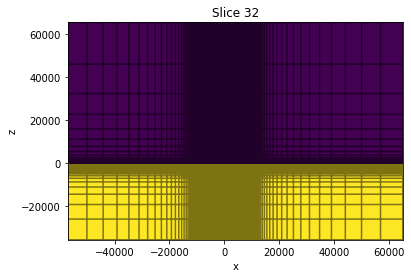

In [2199]:
mesh_b.plotSlice(mesh_b.gridCC[:,2]<0., normal='Y', grid=True)

### create the octree mesh

In [2200]:
# # define the base mesh
# def make_mesh(refine_blocks = False):
#     mesh = discretize.TreeMesh(
#         [
#             [(dx, npad_x, -pf), (dx, ncx-npad_x*2), (dx, npad_x, pf)], 
#             [(dy, npad_y, -pf), (dy, ncy-npad_y*2), (dy, npad_y, pf)], 
#             [(dz, npad_z, -pfz), (dz, ncz-npad_z*2), (dz, npad_z, pfz)]
#         ]
#     )

#     mesh.x0 = np.r_[
#         -np.sum(mesh.h[0])/2., -np.sum(mesh.h[1])/2., -np.sum(mesh.h[2][:ncz-npad_z])
#     ]


#     # refine around the layers 
#     xrefine = domain_x*2*np.r_[-1, 1]
#     yrefine = domain_x*1.5*np.r_[-1, 1]

#     for d in depth: 
#         xr, yr, zr = np.meshgrid(xrefine, yrefine, np.r_[d])
#         surface_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
#         mesh = discretize.utils.refine_tree_xyz(
#             mesh, surface_refine, 
#             octree_levels=[1, 1], method="surface", finalize=False
#         )

#     # refine around the sources and receivers
#     xr, yr, zr = np.meshgrid(src[0:2], src[2] + dy/2*np.r_[-1, 1], src[4] + dz/2*np.r_[-1, 1]) 
#     src_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
#     mesh = discretize.utils.refine_tree_xyz(
#         mesh, src_refine, 
#         octree_levels=[4, 4, 2, 2], method="box", finalize=False
#     )

#     mesh = discretize.utils.refine_tree_xyz(
#         mesh, rx_locs, 
#         octree_levels=[8, 8, 2, 2], method="radial", finalize=False
#     )

#     if refine_blocks:
#         # refine around the blocks
#         for b in [block1, block2, block3]:
#             for xb, yb, zb in zip(
#                 [b[0], b[1], b[0:2], b[0:2], b[0:2], b[0:2]], # x
#                 [b[2:4], b[2:4], b[2], b[3], b[2:4], b[2:4]], # y
#                 [b[4:6], b[4:6], b[4:6], b[4:6], b[4], b[5]]  # z
#             ):
#                 if not isinstance(xb, list):
#                     xb = xb + 2*dx*np.r_[-1, 1]
#                 elif not isinstance(yb, list): 
#                     yb = yb + 2*dy*np.r_[-1, 1]
#                 elif not isinstance(zb, list): 
#                     zb = zb + 2*dz*np.r_[-1, 1]

#                 xr, yr, zr = np.meshgrid(xb, yb, zb) 
#                 surface_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
#                 mesh = discretize.utils.refine_tree_xyz(
#                     mesh, surface_refine, 
#                     octree_levels=[1, 1, 1],
#                     method="box", finalize=False
#                 )

#     mesh.finalize()
    
#     return mesh

In [2201]:
# mesh_b = make_mesh(refine_blocks = False)

In [2202]:
print(mesh_b.nC/1e6)

1.572864


In [2203]:
mesh_b

TensorMesh: 1,572,864 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    256    -57,087.78     65,201.21    100.00  8,113.42    1.17
   y     64    -51,967.77     51,967.77    200.00 14,623.87    1.43
   z     96    -35,514.71     65,482.02     50.00 19,403.13    1.42

In [2204]:
def plot_mesh(normal="Y", ind=1024, xmin=-10000, xmax=10000, ymin=-4000, ymax=100):
    fig, ax = plt.subplots(1, 1)
    mesh_b.plotSlice(np.log10(mesh_b.vol), normal=normal, grid=True, ax=ax, ind=ind)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

In [2205]:
max_h = np.max([len(h) for h in mesh_b.h])
ipywidgets.interact(
    plot_mesh,
    normal=ipywidgets.ToggleButtons(options=["X", "Y", "Z"], value="Y"),
    ind=ipywidgets.IntSlider(min=0, max=max_h, value=int(len(mesh_b.h[1])/2)),
    xmin=ipywidgets.FloatText(value=-domain_x),
    xmax=ipywidgets.FloatText(value=domain_x),
    ymin=ipywidgets.FloatText(value=-4000),
    ymax=ipywidgets.FloatText(value=100)
)

interactive(children=(ToggleButtons(description='normal', index=1, options=('X', 'Y', 'Z'), value='Y'), IntSli…

<function __main__.plot_mesh(normal='Y', ind=1024, xmin=-10000, xmax=10000, ymin=-4000, ymax=100)>

### put the model on the computational mesh

In [2206]:
def build_model(mesh):
    rhoh = np.ones(mesh.nC) * res1d[-1]
    rhov = np.ones(mesh.nC) * res1d[-1] *aniso[-1]
    for ii in [3, 2, 1, 0]:
        inds = mesh.gridCC[:,2]>depth[ii]
        rhoh[inds] = res1d[ii]
        rhov[inds] = res1d[ii] *aniso[ii]**2
    return rhoh, rhov

In [2207]:
aniso

[1, 1, 1, 1.4142135623730951, 1]

In [2208]:
res1d

[100000000.0, 0.3, 1, 2, 1000]

In [2209]:
# rhoh_b, rhov_b = build_model(mesh_b, False)
# rhoh_b, rhov_b = build_model(mesh_b)

In [2210]:
rhov_b[rhoh_b == 0.3]

array([], dtype=float64)

In [2211]:
rhoh_b[rhoh_b == 0.3]

array([], dtype=float64)

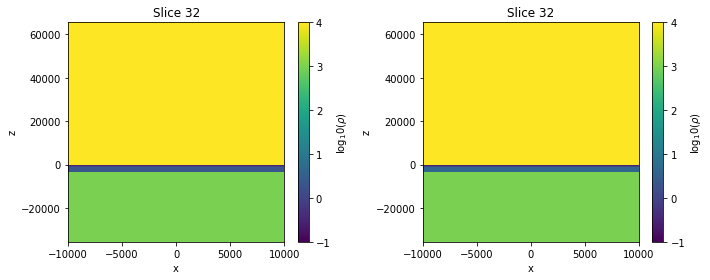

In [2212]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ii = 3
for a, m, mesh in zip(
    ax.flatten(), 
    [rhoh_b, rhov_b], #rhoh_t, rhov_t], 
    [mesh_b, mesh_b], #mesh_t, mesh_t]
):
    cb = plt.colorbar(
        mesh.plotSlice(np.log10(m), ax=a, normal='Y', clim=(-1, 4))[0], ax=a
    )
    cb.set_label("log$_10$($\\rho$)")
    a.set_xlim(0.5*domain_x*np.r_[-1, 1])
#     a.set_ylim([-500 + depth[ii], 500 + depth[ii]])

plt.tight_layout()

In [2213]:
rho_b = np.vstack([rhoh_b, rhoh_b, rhov_b]).T

## set up the frequency domain simulation

In [2214]:
rx_re = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="real")
rx_im = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="imag")

In [2215]:
def build_source(mesh): 
    src_x = np.zeros(mesh.nEx)
    src_inds = (
        (mesh.gridEx[:, 0] >= src[0] - 1) & (mesh.gridEx[:, 0] <= src[1] + 1) &
        (mesh.gridEx[:, 1] >= src[2] - 1) & (mesh.gridEx[:, 1] <= src[3] + 1) &
        (mesh.gridEx[:, 2] >= src[4] - 1) & (mesh.gridEx[:, 2] <= src[5] + 1) 
    )
    src_x[src_inds] = 1
    print(src_inds.nonzero())

    src_vec = strength * mesh.edge * np.hstack([
        src_x, np.zeros(mesh.nEy), np.zeros(mesh.nEz)
    ])
    source = fdem.sources.RawVec_e(s_e=src_vec, freq=freq, receiver_list=[rx_re, rx_im])
    return source

In [2355]:
strength

800.0

In [2356]:
source_b = build_source(mesh_b)

(array([1123198, 1123199, 1123200]),)


In [2250]:
tmp = np.array([1123198, 1123199, 1123200])
mesh_b.gridEx[tmp, :]

array([[-9.99999980e+01,  1.00000034e-06, -5.49999999e+02],
       [ 2.00000795e-06,  1.00000034e-06, -5.49999999e+02],
       [ 1.00000002e+02,  1.00000034e-06, -5.49999999e+02]])

In [2217]:
survey_b = fdem.Survey([source_b])

In [2218]:
sim_b = fdem.Simulation3DElectricField(
    mesh=mesh_b, solver=Pardiso, solverOpts={"is_symmetric":True}, survey=survey_b, rho=rho_b
)

In [2219]:
sim_b.solver

pymatsolver.direct.Pardiso

In [ ]:
%%time
t0 = time.time()
mem_b = %memit -o fields_b = sim_b.fields()
time_b = time.time()-t0
ram_b = f"{(mem_b.mem_usage[0] - mem_b.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram_b}")

In [ ]:
from scipy import interpolate 

In [2296]:
n_data_locs = rx_re.locs.shape[0]
data_re_rbf = np.zeros(n_data_locs)
data_im_rbf = np.zeros(n_data_locs)

ncells_interp = 4 
dx_interp = ncells_interp * dx
dy_interp = ncells_interp * dy
dz_interp = ncells_interp * dz

ex = fields_b[:, "e"][:mesh_b.nEx]

for i in range(n_data_locs):
    inds = (
        (mesh_b.gridEx[:, 0] >= rx_re.locs[i, 0] - dx_interp) & 
        (mesh_b.gridEx[:, 0] <= rx_re.locs[i, 0] + dx_interp) &
        (mesh_b.gridEx[:, 1] >= rx_re.locs[i, 1] - dy_interp) & 
        (mesh_b.gridEx[:, 1] <= rx_re.locs[i, 1] + dy_interp) &
        (mesh_b.gridEx[:, 2] >= rx_re.locs[i, 2] - dz_interp) & 
        (mesh_b.gridEx[:, 2] <= rx_re.locs[i, 2] + dz_interp) 
    )
    
    grid = mesh_b.gridEx[inds, :]
    ex_re = ex[inds].real
    ex_im = ex[inds].imag
    
    rbf_re = interpolate.Rbf(grid[:, 0], grid[:, 1], grid[:, 2], ex_re) #, function="cubic")
    rbf_im = interpolate.Rbf(grid[:, 0], grid[:, 1], grid[:, 2], ex_im) #, function="cubic")
    
    data_re_rbf[i] = rbf_re(rx_re.locs[i, 0], rx_re.locs[i, 1], rx_re.locs[i, 2])
    data_im_rbf[i] = rbf_im(rx_re.locs[i, 0], rx_re.locs[i, 1], rx_re.locs[i, 2])
d_b_rbf = np.hstack([data_re_rbf, data_im_rbf])

In [2341]:
d_b = sim_b.dpred(f=fields_b)  # this uses linear interpolation 

In [2342]:
# reshape data to desired shape

def get_data_lines(data): 
    d_re = data[:rx_locs.shape[0]]
    d_im = data[rx_locs.shape[0]:]

    d_line1 = np.vstack([d_re[:101], d_im[:101]]).T
    d_line2 = np.vstack([d_re[101:202], d_im[101:202]]).T
    d_line3 = np.vstack([d_re[202:], d_im[202:]]).T
    #1.5 is due to the length of the bipole
    return [d_line1/1.5, d_line2/1.5, d_line3/1.5]

data_b_lines = get_data_lines(d_b)

In [2343]:
# data_b_lines_rbf = get_data_lines(d_b_rbf)
data_b_lines_rbf = data_b_lines.copy() 

In [2344]:
def extract_lines(name):
    import xarray as xr
    inp = xr.load_dataset(name, engine='h5netcdf')
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out

epm_1d = extract_lines('../results/layered_empymod.nc')

In [2346]:
def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

In [2347]:
# Calculate error
error = {}
spg_data = np.vstack([d[:, 0] + 1j*d[:, 1] for d in data_b_lines_rbf]).T

# spg_data = np.vstack(data_back_lines).T
for name, data in zip(['SimPEG'], [spg_data]):
    rerr = np.clip(100*abs((epm_1d.real-data.real)/epm_1d.real), 0.01, 100)
    ierr = np.clip(100*abs((epm_1d.imag-data.imag)/epm_1d.imag), 0.01, 100)
    error[name] = rerr + 1j*ierr

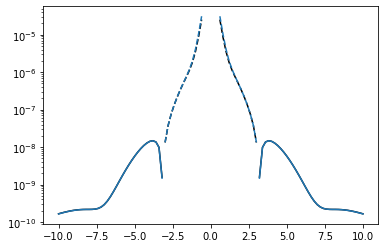

In [2348]:
iy = 1
i=0
resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].imag, off, min_offset)
plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
plt.plot(rec_x/1e3, resp_neg, 'k--')

resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].imag, off, min_offset)
plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
plt.yscale('log')

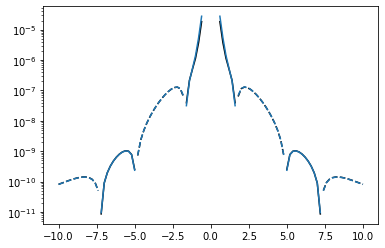

In [2349]:
resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].real, off, min_offset)
plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
plt.plot(rec_x/1e3, resp_neg, 'k--')

resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].real, off, min_offset)
plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
plt.yscale('log')

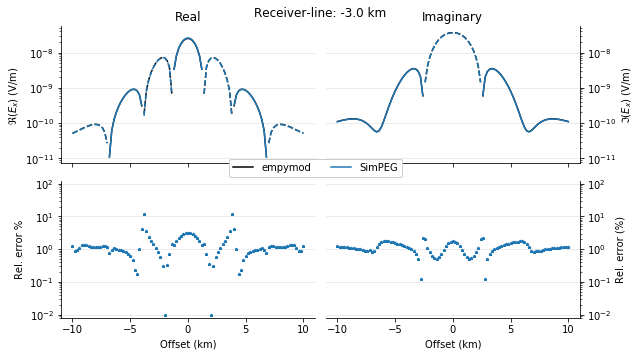

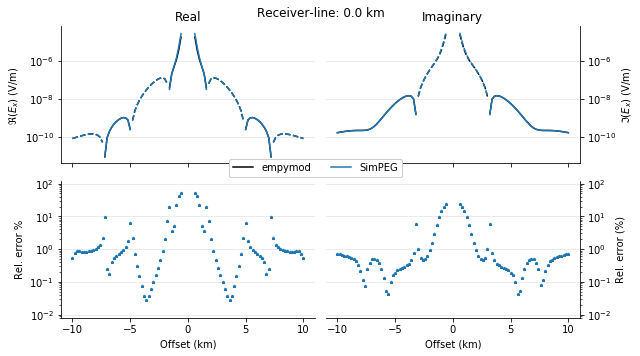

In [2287]:
marker = ['*', 'v', '^', 'o']
min_offset = 500

for iy, y in enumerate(rec_y[:2]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C0-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C0--', ms=3)


    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real Error
    ax2 = plt.subplot(223)

    for i, name in enumerate(error.keys()):
        error[name][off < min_offset, iy] = np.nan + 1j*np.nan
        plt.plot(rec_x/1e3, error[name][:, iy].real, f'C{i}{marker[i]}', ms=3)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Rel. error %')
#     plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
    
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary Error
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(error.keys()):
        plt.plot(rec_x/1e3, error[name][:, iy].imag, f'C{i}{marker[i]}', ms=3)

    # Legend
    plt.plot(0, -1, 'k', label='empymod')
    for i, name in enumerate(error.keys()):
        plt.plot(0, -1, f'C{i}', label=name)
        
    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Rel. error (%)')
    plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.legend(loc=2, ncol=2, bbox_to_anchor=(-0.4, 1.2), framealpha=1)
    
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()

In [2334]:
np.median(epm_1d.real)

nan

In [2335]:
tmp = epm_1d.real / spg_data.real
1./np.median(tmp[~np.isnan(tmp)])

0.9917677229221163

In [2336]:
for i in range(3):
    print(f"Line {i}")
    inds = ~ np.isnan(error['SimPEG'][:, i])
    print(f"mean real: {np.mean(error['SimPEG'][inds, i].real):1.2f}, imag: {np.mean(error['SimPEG'][inds, i].imag):1.2f}")
    print(f"median  real: {np.median(error['SimPEG'][inds, i].real):1.2f}, imag: {np.median(error['SimPEG'][inds, i].imag):1.2f}")             
    print("\n")
                  

Line 0
mean real: 1.48, imag: 1.15
median  real: 1.18, imag: 1.09


Line 1
mean real: 5.45, imag: 2.52
median  real: 0.86, imag: 0.49


Line 2
mean real: 1.48, imag: 1.15
median  real: 1.18, imag: 1.09




In [2337]:
save_results = True

In [2338]:
if save_results: 
    # Save the three lines
    ds.line_1.data = np.vstack([spg_data[:, 0].real, spg_data[:, 0].imag]).ravel('F')
    ds.line_2.data = np.vstack([spg_data[:, 1].real, spg_data[:, 1].imag]).ravel('F')
    ds.line_3.data = np.vstack([spg_data[:, 2].real, spg_data[:, 2].imag]).ravel('F')

    # Add info
    ds.attrs['runtime'] = time_b
    ds.attrs['n_procs'] = 1
    ds.attrs['max_ram'] = ram_b
    ds.attrs['n_cells'] = f"{mesh_b.nC}"
    ds.attrs['n_nodes'] = 'N/A'
    ds.attrs['n_dof'] = f"{mesh.nE}"
    ds.attrs['extent'] = (f"x = {mesh_b.vectorNx[0]:.1f}-{mesh_b.vectorNx[-1]:.1f}; " # Total mesh extent
                          f"y = {mesh_b.vectorNy[0]:.1f}-{mesh_b.vectorNy[-1]:.1f}; "
                          f"z = {mesh_b.vectorNz[0]:.1f}-{mesh_b.vectorNz[-1]:.1f}")
    ds.attrs['min_vol'] = f"{np.min(mesh_b.vol):.1f}"
    ds.attrs['max_vol'] = f"{np.max(mesh_b.vol):.1f}"
    ds.attrs['machine'] = "GKE e2-highmem-16; Intel(R) Xeon(R) CPU @ 2.20GHz; 64GB RAM"
    ds.attrs['version'] = f"SimPEG v{SimPEG.__version__}"
    ds.attrs['date'] = datetime.today().isoformat()

    # Save it under <{model}_{code}.nc>
    ds.to_netcdf(f"../results/layered_simpeg_tensor.nc", engine='h5netcdf')

In [2340]:
# ds

In [2293]:
# # Save the three lines
# ds.line_1.data = np.vstack([spg_data_t[:, 0].real, spg_data_t[:, 0].imag]).ravel('F')
# ds.line_2.data = np.vstack([spg_data_t[:, 1].real, spg_data_t[:, 1].imag]).ravel('F')
# ds.line_3.data = np.vstack([spg_data_t[:, 2].real, spg_data_t[:, 2].imag]).ravel('F')

# # Add info
# ds.attrs['runtime'] = time_t
# ds.attrs['n_procs'] = 1
# ds.attrs['max_ram'] = ram_t
# ds.attrs['n_cells'] = f"{mesh_t.nC}"
# ds.attrs['n_nodes'] = 'N/A'
# ds.attrs['n_dof'] = f"{mesh.nE}"
# ds.attrs['extent'] = (f"x = {mesh_t.vectorNx[0]:.1f}-{mesh_t.vectorNx[-1]:.1f}; " # Total mesh extent
#                       f"y = {mesh_t.vectorNy[0]:.1f}-{mesh_t.vectorNy[-1]:.1f}; "
#                       f"z = {mesh_t.vectorNz[0]:.1f}-{mesh_t.vectorNz[-1]:.1f}")
# ds.attrs['min_vol'] = f"{np.min(mesh_t.vol):.1f}"
# ds.attrs['max_vol'] = f"{np.max(mesh_t.vol):.1f}"
# ds.attrs['machine'] = "Cheyenne Supercomputer - shared node; Intel(R) Xeon(R) CPU E5-2697 v4 @ 2.30GHz"
# ds.attrs['version'] = f"SimPEG v{SimPEG.__version__}"
# ds.attrs['date'] = datetime.today().isoformat()

# # Save it under <{model}_{code}.nc>
# ds.to_netcdf(f"../results/block_simpeg.nc", engine='h5netcdf')